# 20-13. 프로젝트 : Segmentation map으로 도로 이미지 만들기

## 프로젝트 수행 

프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

### 1.데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.
    (어떠한 방법을 사용했는지 적어주세요.) 

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


#### 데이터를 불러오니 1000개의 이미지가 확인되네요.

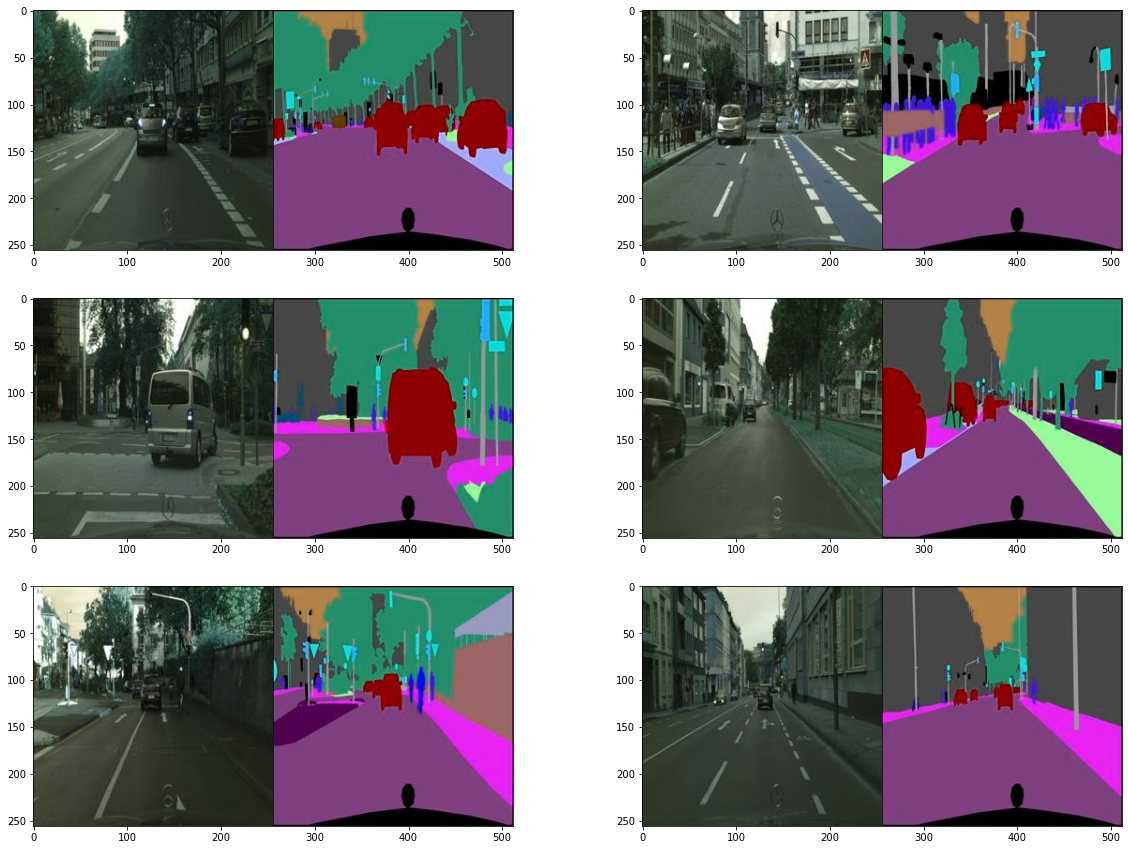

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

#### 임의로 6장의 학습 데이터셋을 시각화 해보았습니다.

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


#### 이미지 하나를 열어 크기를 확인해 보니 256*256 이네요.

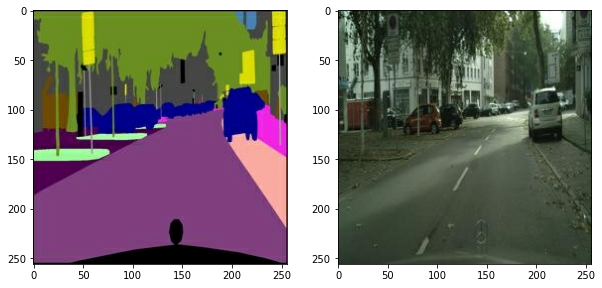

In [4]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

#### 이미지를 (256, 256, 3)크기의 이미지 2개로 분할 했습니다.

In [5]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


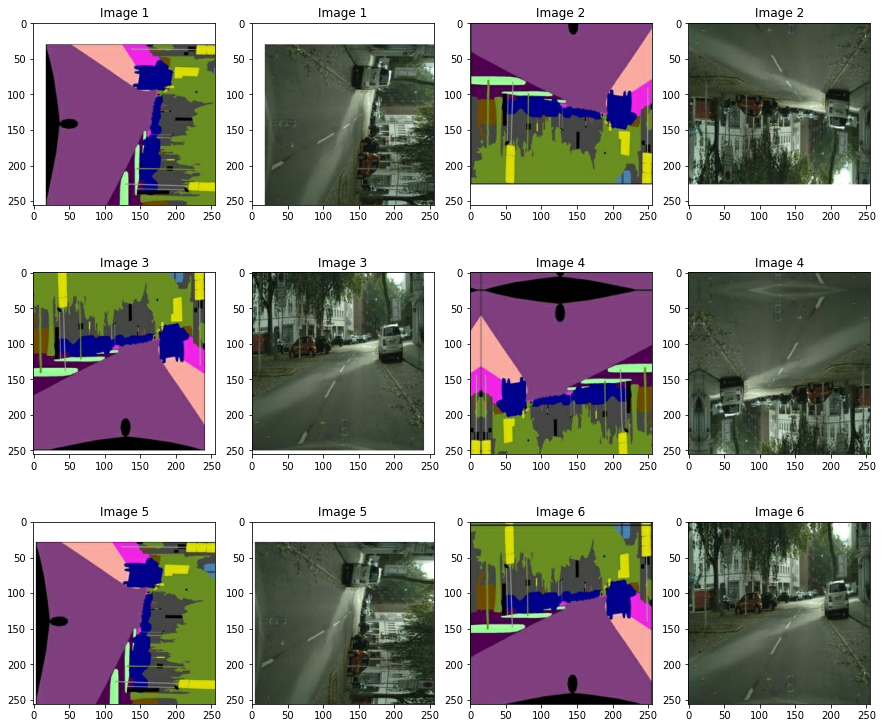

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

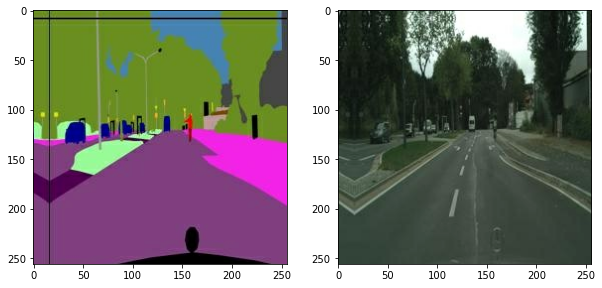

In [7]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

####  apply_augmentation을 이용해 데이터의 수를 늘려 보았습니다. 다양한 이미지가 생성 되었네요

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [9]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [10]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [11]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [12]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [13]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


#### Encoder와 Decoder를 연결시켜 Generator를 구를해 보았습니다

### 2.이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요. 

In [14]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [15]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [16]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

#### 학습 성능을 높이기 위해 Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조를 사용해 보겠습니다.

In [17]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [18]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [19]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [20]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

#### Discriminator를 만들어 Pix2Pix 구조를 완성시켜 보았습니다

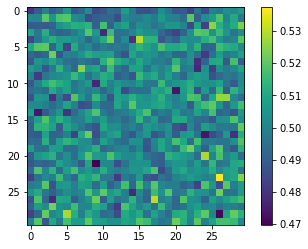

In [21]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

#### 시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화해 보았습니다

### 3.모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요. 

In [22]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [23]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [24]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [25]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9596                     
L1_loss:0.3324                     
Discriminator_loss:1.2913

EPOCH[1] - STEP[20]                     
Generator_loss:0.9896                     
L1_loss:0.2104                     
Discriminator_loss:1.1566

EPOCH[1] - STEP[30]                     
Generator_loss:1.1005                     
L1_loss:0.1618                     
Discriminator_loss:1.3634

EPOCH[1] - STEP[40]                     
Generator_loss:0.7810                     
L1_loss:0.1865                     
Discriminator_loss:1.2496

EPOCH[1] - STEP[50]                     
Generator_loss:1.0553                     
L1_loss:0.2261                     
Discriminator_loss:1.1792

EPOCH[1] - STEP[60]                     
Generator_loss:0.6784                     
L1_loss:0.2204                     
Discriminator_loss:1.2590

EPOCH[1] - STEP[70]                     
Generator_loss:0.9153                     
L1_loss:0.1603                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.1333                     
L1_loss:0.1858                     
Discriminator_loss:0.7802

EPOCH[3] - STEP[80]                     
Generator_loss:1.0173                     
L1_loss:0.1776                     
Discriminator_loss:0.6846

EPOCH[3] - STEP[90]                     
Generator_loss:1.9302                     
L1_loss:0.1517                     
Discriminator_loss:1.5558

EPOCH[3] - STEP[100]                     
Generator_loss:2.8538                     
L1_loss:0.1589                     
Discriminator_loss:0.7826

EPOCH[3] - STEP[110]                     
Generator_loss:0.9086                     
L1_loss:0.2253                     
Discriminator_loss:0.6924

EPOCH[3] - STEP[120]                     
Generator_loss:1.0337                     
L1_loss:0.1700                     
Discriminator_loss:0.8038

EPOCH[3] - STEP[130]                     
Generator_loss:1.9081                     
L1_loss:0.2030                

EPOCH[5] - STEP[130]                     
Generator_loss:0.8166                     
L1_loss:0.1665                     
Discriminator_loss:0.9596

EPOCH[5] - STEP[140]                     
Generator_loss:0.8449                     
L1_loss:0.1845                     
Discriminator_loss:0.7929

EPOCH[5] - STEP[150]                     
Generator_loss:1.2566                     
L1_loss:0.1726                     
Discriminator_loss:0.6826

EPOCH[5] - STEP[160]                     
Generator_loss:1.1816                     
L1_loss:0.1826                     
Discriminator_loss:0.9273

EPOCH[5] - STEP[170]                     
Generator_loss:1.5035                     
L1_loss:0.2071                     
Discriminator_loss:1.4952

EPOCH[5] - STEP[180]                     
Generator_loss:1.1814                     
L1_loss:0.1988                     
Discriminator_loss:0.6009

EPOCH[5] - STEP[190]                     
Generator_loss:0.8730                     
L1_loss:0.1644             

EPOCH[7] - STEP[190]                     
Generator_loss:1.4630                     
L1_loss:0.2254                     
Discriminator_loss:0.4726

EPOCH[7] - STEP[200]                     
Generator_loss:1.3963                     
L1_loss:0.1976                     
Discriminator_loss:0.4474

EPOCH[7] - STEP[210]                     
Generator_loss:1.0844                     
L1_loss:0.1969                     
Discriminator_loss:0.5818

EPOCH[7] - STEP[220]                     
Generator_loss:2.0082                     
L1_loss:0.1609                     
Discriminator_loss:1.0980

EPOCH[7] - STEP[230]                     
Generator_loss:0.8919                     
L1_loss:0.1840                     
Discriminator_loss:1.0725

EPOCH[7] - STEP[240]                     
Generator_loss:2.4525                     
L1_loss:0.1703                     
Discriminator_loss:1.6110

EPOCH[7] - STEP[250]                     
Generator_loss:0.9896                     
L1_loss:0.1546             

EPOCH[9] - STEP[250]                     
Generator_loss:2.4222                     
L1_loss:0.1989                     
Discriminator_loss:0.4505

EPOCH[10] - STEP[10]                     
Generator_loss:1.4658                     
L1_loss:0.2117                     
Discriminator_loss:0.5900

EPOCH[10] - STEP[20]                     
Generator_loss:1.7330                     
L1_loss:0.1893                     
Discriminator_loss:0.3393

EPOCH[10] - STEP[30]                     
Generator_loss:1.9366                     
L1_loss:0.1829                     
Discriminator_loss:0.4105

EPOCH[10] - STEP[40]                     
Generator_loss:1.9652                     
L1_loss:0.1447                     
Discriminator_loss:1.9070

EPOCH[10] - STEP[50]                     
Generator_loss:2.0802                     
L1_loss:0.2009                     
Discriminator_loss:0.3101

EPOCH[10] - STEP[60]                     
Generator_loss:0.4856                     
L1_loss:0.1904             

EPOCH[12] - STEP[60]                     
Generator_loss:1.0615                     
L1_loss:0.1754                     
Discriminator_loss:0.6194

EPOCH[12] - STEP[70]                     
Generator_loss:1.7845                     
L1_loss:0.1714                     
Discriminator_loss:1.6393

EPOCH[12] - STEP[80]                     
Generator_loss:3.2026                     
L1_loss:0.1653                     
Discriminator_loss:1.8147

EPOCH[12] - STEP[90]                     
Generator_loss:2.0365                     
L1_loss:0.2114                     
Discriminator_loss:0.2358

EPOCH[12] - STEP[100]                     
Generator_loss:1.3444                     
L1_loss:0.1578                     
Discriminator_loss:1.1403

EPOCH[12] - STEP[110]                     
Generator_loss:1.3035                     
L1_loss:0.1723                     
Discriminator_loss:0.5187

EPOCH[12] - STEP[120]                     
Generator_loss:0.3185                     
L1_loss:0.1691          

EPOCH[14] - STEP[120]                     
Generator_loss:1.1022                     
L1_loss:0.1720                     
Discriminator_loss:1.0757

EPOCH[14] - STEP[130]                     
Generator_loss:1.5515                     
L1_loss:0.1918                     
Discriminator_loss:0.6638

EPOCH[14] - STEP[140]                     
Generator_loss:2.5815                     
L1_loss:0.1752                     
Discriminator_loss:0.8176

EPOCH[14] - STEP[150]                     
Generator_loss:1.2623                     
L1_loss:0.1818                     
Discriminator_loss:0.6163

EPOCH[14] - STEP[160]                     
Generator_loss:3.2924                     
L1_loss:0.1586                     
Discriminator_loss:0.8518

EPOCH[14] - STEP[170]                     
Generator_loss:2.6294                     
L1_loss:0.1847                     
Discriminator_loss:0.4117

EPOCH[14] - STEP[180]                     
Generator_loss:1.0900                     
L1_loss:0.1912      

EPOCH[16] - STEP[180]                     
Generator_loss:0.4104                     
L1_loss:0.1742                     
Discriminator_loss:1.5516

EPOCH[16] - STEP[190]                     
Generator_loss:1.1999                     
L1_loss:0.1632                     
Discriminator_loss:0.5291

EPOCH[16] - STEP[200]                     
Generator_loss:1.1945                     
L1_loss:0.1376                     
Discriminator_loss:0.8265

EPOCH[16] - STEP[210]                     
Generator_loss:0.9619                     
L1_loss:0.1836                     
Discriminator_loss:0.8871

EPOCH[16] - STEP[220]                     
Generator_loss:0.3164                     
L1_loss:0.2138                     
Discriminator_loss:2.1427

EPOCH[16] - STEP[230]                     
Generator_loss:1.5490                     
L1_loss:0.1653                     
Discriminator_loss:0.6995

EPOCH[16] - STEP[240]                     
Generator_loss:1.1871                     
L1_loss:0.1832      

EPOCH[18] - STEP[240]                     
Generator_loss:1.3835                     
L1_loss:0.1840                     
Discriminator_loss:0.3954

EPOCH[18] - STEP[250]                     
Generator_loss:1.2654                     
L1_loss:0.1444                     
Discriminator_loss:0.9971

EPOCH[19] - STEP[10]                     
Generator_loss:0.7750                     
L1_loss:0.1562                     
Discriminator_loss:1.3864

EPOCH[19] - STEP[20]                     
Generator_loss:1.2428                     
L1_loss:0.1613                     
Discriminator_loss:0.9027

EPOCH[19] - STEP[30]                     
Generator_loss:1.9633                     
L1_loss:0.2064                     
Discriminator_loss:0.3466

EPOCH[19] - STEP[40]                     
Generator_loss:1.2197                     
L1_loss:0.1802                     
Discriminator_loss:0.6585

EPOCH[19] - STEP[50]                     
Generator_loss:1.6981                     
L1_loss:0.1535           

EPOCH[21] - STEP[50]                     
Generator_loss:0.8817                     
L1_loss:0.1760                     
Discriminator_loss:0.9026

EPOCH[21] - STEP[60]                     
Generator_loss:1.2985                     
L1_loss:0.1470                     
Discriminator_loss:1.4197

EPOCH[21] - STEP[70]                     
Generator_loss:1.1872                     
L1_loss:0.2354                     
Discriminator_loss:0.4330

EPOCH[21] - STEP[80]                     
Generator_loss:0.8390                     
L1_loss:0.1697                     
Discriminator_loss:0.9660

EPOCH[21] - STEP[90]                     
Generator_loss:2.2908                     
L1_loss:0.1860                     
Discriminator_loss:0.4827

EPOCH[21] - STEP[100]                     
Generator_loss:1.5950                     
L1_loss:0.1580                     
Discriminator_loss:0.6044

EPOCH[21] - STEP[110]                     
Generator_loss:0.2989                     
L1_loss:0.1724           

EPOCH[23] - STEP[110]                     
Generator_loss:0.9734                     
L1_loss:0.1968                     
Discriminator_loss:0.6766

EPOCH[23] - STEP[120]                     
Generator_loss:2.0163                     
L1_loss:0.1485                     
Discriminator_loss:0.9851

EPOCH[23] - STEP[130]                     
Generator_loss:1.2652                     
L1_loss:0.1825                     
Discriminator_loss:0.6226

EPOCH[23] - STEP[140]                     
Generator_loss:1.1761                     
L1_loss:0.1555                     
Discriminator_loss:1.0864

EPOCH[23] - STEP[150]                     
Generator_loss:1.0496                     
L1_loss:0.1858                     
Discriminator_loss:0.7854

EPOCH[23] - STEP[160]                     
Generator_loss:0.6042                     
L1_loss:0.1968                     
Discriminator_loss:1.0747

EPOCH[23] - STEP[170]                     
Generator_loss:1.8803                     
L1_loss:0.1967      

EPOCH[25] - STEP[170]                     
Generator_loss:0.4790                     
L1_loss:0.1971                     
Discriminator_loss:1.2360

EPOCH[25] - STEP[180]                     
Generator_loss:1.8018                     
L1_loss:0.1546                     
Discriminator_loss:0.9962

EPOCH[25] - STEP[190]                     
Generator_loss:0.5727                     
L1_loss:0.1841                     
Discriminator_loss:0.9872

EPOCH[25] - STEP[200]                     
Generator_loss:1.1290                     
L1_loss:0.1563                     
Discriminator_loss:1.3782

EPOCH[25] - STEP[210]                     
Generator_loss:1.2127                     
L1_loss:0.2145                     
Discriminator_loss:0.4160

EPOCH[25] - STEP[220]                     
Generator_loss:2.0055                     
L1_loss:0.1745                     
Discriminator_loss:1.2791

EPOCH[25] - STEP[230]                     
Generator_loss:0.5689                     
L1_loss:0.1881      

EPOCH[27] - STEP[230]                     
Generator_loss:1.2859                     
L1_loss:0.1526                     
Discriminator_loss:1.9607

EPOCH[27] - STEP[240]                     
Generator_loss:1.7414                     
L1_loss:0.1554                     
Discriminator_loss:1.7029

EPOCH[27] - STEP[250]                     
Generator_loss:2.0014                     
L1_loss:0.1496                     
Discriminator_loss:2.1362

EPOCH[28] - STEP[10]                     
Generator_loss:0.3686                     
L1_loss:0.1733                     
Discriminator_loss:1.3607

EPOCH[28] - STEP[20]                     
Generator_loss:1.8384                     
L1_loss:0.1865                     
Discriminator_loss:0.3857

EPOCH[28] - STEP[30]                     
Generator_loss:2.0781                     
L1_loss:0.1476                     
Discriminator_loss:1.8007

EPOCH[28] - STEP[40]                     
Generator_loss:0.8379                     
L1_loss:0.1518          

EPOCH[30] - STEP[40]                     
Generator_loss:2.0977                     
L1_loss:0.1955                     
Discriminator_loss:0.5966

EPOCH[30] - STEP[50]                     
Generator_loss:1.0779                     
L1_loss:0.2046                     
Discriminator_loss:0.8407

EPOCH[30] - STEP[60]                     
Generator_loss:1.6265                     
L1_loss:0.1948                     
Discriminator_loss:0.3260

EPOCH[30] - STEP[70]                     
Generator_loss:1.2542                     
L1_loss:0.1635                     
Discriminator_loss:1.8989

EPOCH[30] - STEP[80]                     
Generator_loss:0.4677                     
L1_loss:0.2259                     
Discriminator_loss:1.1414

EPOCH[30] - STEP[90]                     
Generator_loss:0.7175                     
L1_loss:0.1505                     
Discriminator_loss:0.9380

EPOCH[30] - STEP[100]                     
Generator_loss:0.7957                     
L1_loss:0.1613            

EPOCH[32] - STEP[100]                     
Generator_loss:1.4183                     
L1_loss:0.1876                     
Discriminator_loss:0.5656

EPOCH[32] - STEP[110]                     
Generator_loss:1.9234                     
L1_loss:0.2343                     
Discriminator_loss:0.3091

EPOCH[32] - STEP[120]                     
Generator_loss:1.8242                     
L1_loss:0.1814                     
Discriminator_loss:0.5631

EPOCH[32] - STEP[130]                     
Generator_loss:0.4539                     
L1_loss:0.1860                     
Discriminator_loss:1.3138

EPOCH[32] - STEP[140]                     
Generator_loss:2.2447                     
L1_loss:0.1745                     
Discriminator_loss:1.0543

EPOCH[32] - STEP[150]                     
Generator_loss:1.4533                     
L1_loss:0.1998                     
Discriminator_loss:0.6023

EPOCH[32] - STEP[160]                     
Generator_loss:2.0681                     
L1_loss:0.1729      

EPOCH[34] - STEP[160]                     
Generator_loss:1.6030                     
L1_loss:0.1495                     
Discriminator_loss:0.8728

EPOCH[34] - STEP[170]                     
Generator_loss:2.2775                     
L1_loss:0.1717                     
Discriminator_loss:0.5480

EPOCH[34] - STEP[180]                     
Generator_loss:1.6958                     
L1_loss:0.1965                     
Discriminator_loss:0.6713

EPOCH[34] - STEP[190]                     
Generator_loss:2.3516                     
L1_loss:0.1825                     
Discriminator_loss:1.1024

EPOCH[34] - STEP[200]                     
Generator_loss:1.2952                     
L1_loss:0.1760                     
Discriminator_loss:0.7809

EPOCH[34] - STEP[210]                     
Generator_loss:1.2471                     
L1_loss:0.1635                     
Discriminator_loss:0.7762

EPOCH[34] - STEP[220]                     
Generator_loss:1.8790                     
L1_loss:0.1757      

EPOCH[36] - STEP[220]                     
Generator_loss:1.4633                     
L1_loss:0.1680                     
Discriminator_loss:0.4712

EPOCH[36] - STEP[230]                     
Generator_loss:1.3807                     
L1_loss:0.1833                     
Discriminator_loss:0.5761

EPOCH[36] - STEP[240]                     
Generator_loss:1.4317                     
L1_loss:0.1563                     
Discriminator_loss:1.0619

EPOCH[36] - STEP[250]                     
Generator_loss:1.7455                     
L1_loss:0.1971                     
Discriminator_loss:0.2522

EPOCH[37] - STEP[10]                     
Generator_loss:0.6776                     
L1_loss:0.1739                     
Discriminator_loss:1.0119

EPOCH[37] - STEP[20]                     
Generator_loss:0.7694                     
L1_loss:0.2145                     
Discriminator_loss:0.6872

EPOCH[37] - STEP[30]                     
Generator_loss:2.3236                     
L1_loss:0.1784         

EPOCH[39] - STEP[30]                     
Generator_loss:0.3049                     
L1_loss:0.1789                     
Discriminator_loss:1.5824

EPOCH[39] - STEP[40]                     
Generator_loss:0.7780                     
L1_loss:0.1671                     
Discriminator_loss:1.1088

EPOCH[39] - STEP[50]                     
Generator_loss:1.1379                     
L1_loss:0.1695                     
Discriminator_loss:2.1395

EPOCH[39] - STEP[60]                     
Generator_loss:2.2513                     
L1_loss:0.1699                     
Discriminator_loss:1.0180

EPOCH[39] - STEP[70]                     
Generator_loss:2.2289                     
L1_loss:0.1474                     
Discriminator_loss:0.3674

EPOCH[39] - STEP[80]                     
Generator_loss:1.4697                     
L1_loss:0.1994                     
Discriminator_loss:0.5624

EPOCH[39] - STEP[90]                     
Generator_loss:1.3298                     
L1_loss:0.2027             

EPOCH[41] - STEP[90]                     
Generator_loss:0.6167                     
L1_loss:0.1912                     
Discriminator_loss:0.9573

EPOCH[41] - STEP[100]                     
Generator_loss:2.4611                     
L1_loss:0.1585                     
Discriminator_loss:0.6244

EPOCH[41] - STEP[110]                     
Generator_loss:1.5512                     
L1_loss:0.1833                     
Discriminator_loss:0.6252

EPOCH[41] - STEP[120]                     
Generator_loss:1.7549                     
L1_loss:0.1893                     
Discriminator_loss:0.7091

EPOCH[41] - STEP[130]                     
Generator_loss:1.7743                     
L1_loss:0.1795                     
Discriminator_loss:2.3410

EPOCH[41] - STEP[140]                     
Generator_loss:0.8569                     
L1_loss:0.1599                     
Discriminator_loss:1.2472

EPOCH[41] - STEP[150]                     
Generator_loss:1.1783                     
L1_loss:0.1937       

EPOCH[43] - STEP[150]                     
Generator_loss:1.0047                     
L1_loss:0.1649                     
Discriminator_loss:1.0916

EPOCH[43] - STEP[160]                     
Generator_loss:0.5084                     
L1_loss:0.1806                     
Discriminator_loss:1.0963

EPOCH[43] - STEP[170]                     
Generator_loss:1.3394                     
L1_loss:0.2120                     
Discriminator_loss:0.4156

EPOCH[43] - STEP[180]                     
Generator_loss:1.3032                     
L1_loss:0.1874                     
Discriminator_loss:0.7175

EPOCH[43] - STEP[190]                     
Generator_loss:0.9116                     
L1_loss:0.1673                     
Discriminator_loss:1.0383

EPOCH[43] - STEP[200]                     
Generator_loss:0.8683                     
L1_loss:0.1812                     
Discriminator_loss:0.8702

EPOCH[43] - STEP[210]                     
Generator_loss:3.1388                     
L1_loss:0.1692      

EPOCH[45] - STEP[210]                     
Generator_loss:1.5684                     
L1_loss:0.1824                     
Discriminator_loss:0.5185

EPOCH[45] - STEP[220]                     
Generator_loss:0.5601                     
L1_loss:0.1688                     
Discriminator_loss:1.0061

EPOCH[45] - STEP[230]                     
Generator_loss:1.1037                     
L1_loss:0.1629                     
Discriminator_loss:0.7894

EPOCH[45] - STEP[240]                     
Generator_loss:0.5721                     
L1_loss:0.1699                     
Discriminator_loss:1.6893

EPOCH[45] - STEP[250]                     
Generator_loss:0.9178                     
L1_loss:0.1704                     
Discriminator_loss:0.9000

EPOCH[46] - STEP[10]                     
Generator_loss:0.9984                     
L1_loss:0.1650                     
Discriminator_loss:1.1345

EPOCH[46] - STEP[20]                     
Generator_loss:0.9667                     
L1_loss:0.2166        

EPOCH[48] - STEP[20]                     
Generator_loss:2.9496                     
L1_loss:0.1454                     
Discriminator_loss:2.0345

EPOCH[48] - STEP[30]                     
Generator_loss:0.4775                     
L1_loss:0.1695                     
Discriminator_loss:1.2410

EPOCH[48] - STEP[40]                     
Generator_loss:0.9096                     
L1_loss:0.2061                     
Discriminator_loss:0.6369

EPOCH[48] - STEP[50]                     
Generator_loss:1.5044                     
L1_loss:0.1667                     
Discriminator_loss:0.5664

EPOCH[48] - STEP[60]                     
Generator_loss:2.5915                     
L1_loss:0.1925                     
Discriminator_loss:0.6454

EPOCH[48] - STEP[70]                     
Generator_loss:1.3618                     
L1_loss:0.1770                     
Discriminator_loss:0.5533

EPOCH[48] - STEP[80]                     
Generator_loss:0.9491                     
L1_loss:0.2217             

EPOCH[50] - STEP[80]                     
Generator_loss:1.3475                     
L1_loss:0.1866                     
Discriminator_loss:0.3922

EPOCH[50] - STEP[90]                     
Generator_loss:0.9389                     
L1_loss:0.1823                     
Discriminator_loss:0.6062

EPOCH[50] - STEP[100]                     
Generator_loss:1.7486                     
L1_loss:0.1718                     
Discriminator_loss:0.7256

EPOCH[50] - STEP[110]                     
Generator_loss:1.1401                     
L1_loss:0.1629                     
Discriminator_loss:2.1875

EPOCH[50] - STEP[120]                     
Generator_loss:1.1598                     
L1_loss:0.1590                     
Discriminator_loss:2.7162

EPOCH[50] - STEP[130]                     
Generator_loss:1.0419                     
L1_loss:0.1702                     
Discriminator_loss:0.7219

EPOCH[50] - STEP[140]                     
Generator_loss:0.3944                     
L1_loss:0.2700        

#### 50에포크만 학습 시켜 보았습니다. 결과가 어떨지 궁금하네요.

### 4.1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요. 

In [26]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

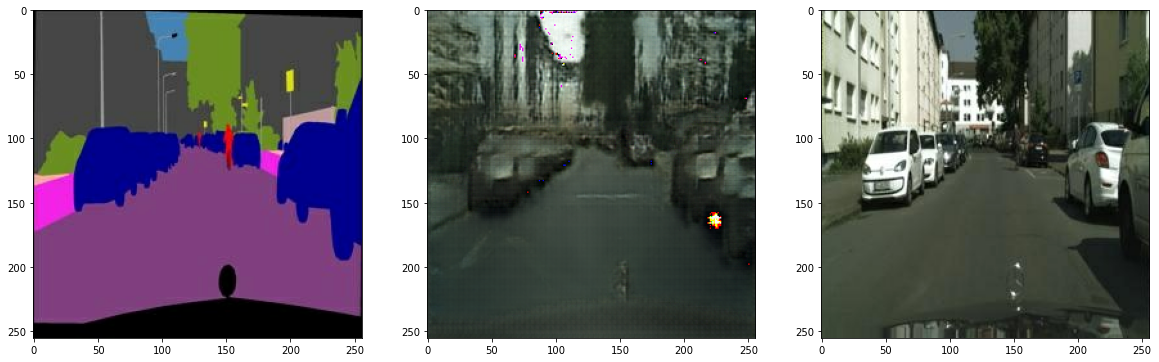

In [27]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

#### 결과를 확인해 보니 완벽하게 재현이 되어 보이지는 않습니다. 아무래도 더 디테일한 설계와 더 긴시간 동안 학습이 필요하겠죠?

## 총평

#### 마지막 EXPLORATION이 끝났습니다 ㅜㅜ. 하지만 더 무서운 Going Deeper가 기다리고 있네요 ㅎㅎ다. 모든걸 완벽하게 채득하진 못했지만 즐겁고도 힘겨운 시간이었습니다. 시간이 되면 다시한번 찬찬히 보면서 예전에는 이해하기 힘들었던 것들을 조금더 잘 살펴보고 싶네요. 퍼실님들도 애 많이 쓰셨습니다. 감사합니다.